# COVID-19 Classification (Python)

The objective of the assignment is to use an algorithm that will predict whether a healthy person, exposed to a positive COVID-19 case, is likely to become a positive case too.

The Modeling step is executed after the *Data exploration* step in a separate notebook. This means that the dataset used has less features as we dropped some of them in the previous step. 

The process implementation was done using the Sklearn pipeline which has the following stages:
1. Transformer pipeline which transforming and separating the data into Numerical and Categorical pipelines:
    - Numerical pipeline:
        - Standardization
        - Finding outliers by LOF algorithm and setting the result into a new feature
    - Categorical pipeline:
        - Merging rare categories by threshold
        - One hot encoding
2. Model pipeline - Several models were tested and optimized by grid search when the model after evaluation with the highest F1 was taken, the best model is  XGBClassifier

Final model pipeline

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.options.plotting.backend = "plotly"

# from utils.functions import data_retrieval
# from pipelines.python_pipelines import *
from utils.visualization import bias_var_plot
from pipelines.pipelines import pipeline
from utils.functions import *

from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV,train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn import set_config
set_config(display='diagram')
from sklearn.utils import estimator_html_repr

import shap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# sns.set_style("darkgrid")
# %matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data.csv', usecols=['feature_3', 'feature_4',  'feature_15', 'label','feature_5', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_11', 'feature_13', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21']).sample(120000)

In the exploration step remove the following features were removed: feature_2,  feature_8, feature_12, feature_14 (feature_7?)

## Pandas & SKlearn

In [3]:
y = df['label']
X = df.drop(['label'], axis=1).copy()

In [4]:
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)

## Find optimal model using baseline models

In [5]:
data_pipeline = pipeline()
X_train = data_pipeline.fit_transform(X_train_pre)
X_test = data_pipeline.transform(X_test_pre)

transform: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 319.38it/s]

(12000, 9)
(12000, 10)



transform: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.36it/s]

(108000, 9)
(108000, 10)


In [7]:
y_train_ratio = (y_train==False).sum()/(y_train==True).sum()

The ratio is used as a hyperparameter in the XGB Classifier in order to balance the labels in the data set (using the cost function penalization) 

In [8]:
classifiers = [
    LogisticRegression(class_weight='balanced', max_iter=1000),
#     SVC(kernel="rbf", C=0.025, probability=True, class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    XGBClassifier(scale_pos_weight = y_train_ratio)
    ]

LogisticRegression f1 0.752 recall 0.829 score
DecisionTreeClassifier f1 0.669 recall 0.622 score
RandomForestClassifier f1 0.696 recall 0.655 score
XGBClassifier f1 0.634 recall 0.583 score


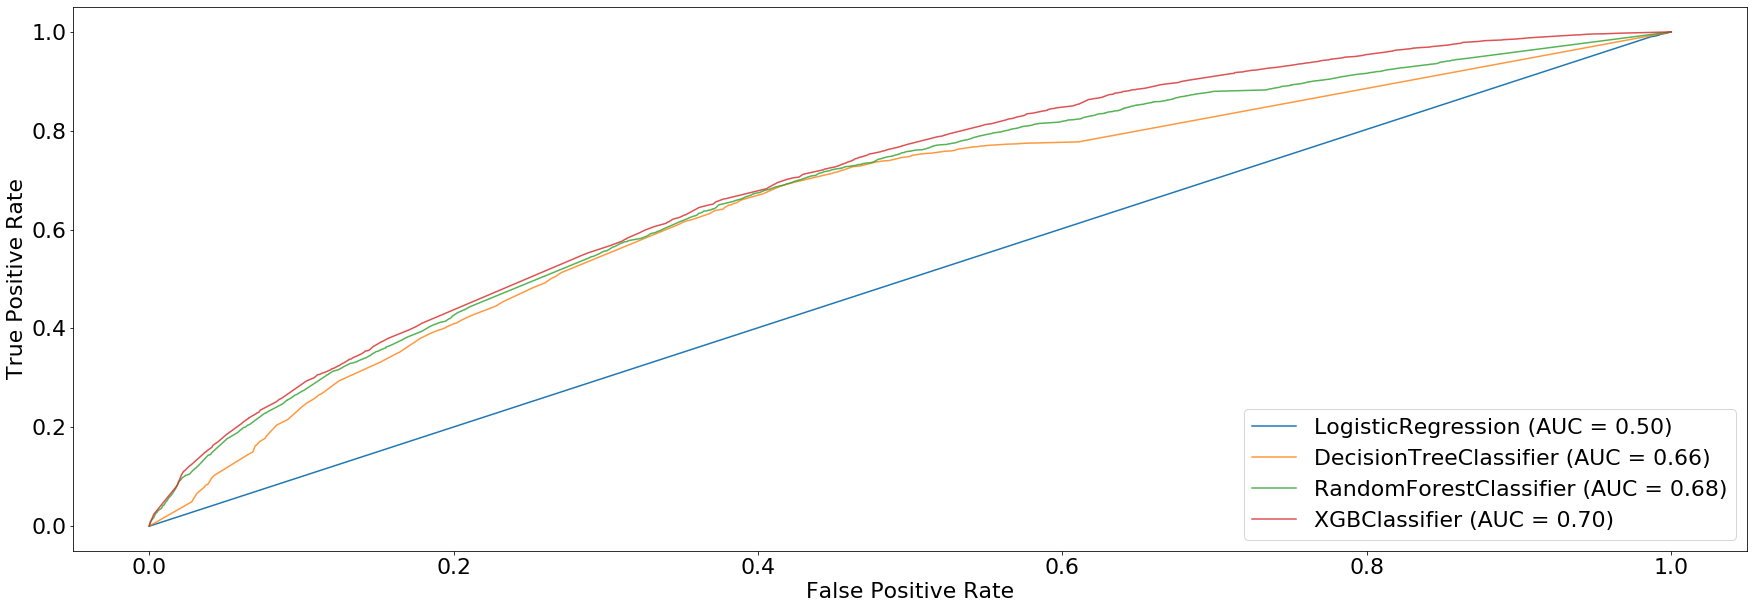

In [27]:
eval_clf(classifiers, X_train, X_test, y_train, y_test)

The main objective is to classify positive COVID-19 , so false negative cases should be at the minimum since we want to stop the infection chain.
The best indicator for that is the *recall* metric but also I should plot an fpr / tpr plot (not a roc curve) in order to find optimal threshold so that the precision won't go down

In [9]:
params_clf = {
              'eval_metric' : "logloss", # 'error'
              'random_state':1,
              'scale_pos_weight' : y_train_ratio,
              'obj':squared_log}

clf = XGBClassifier(**params_clf)

In [10]:
param_grid = { 
            'alpha': [0, 0.3], # L1 regularization 
            'lambda': [1, 0.3], # L2 regularization 
            'min_child_weight': [0.5, 1],
            'learning_rate':[0.05, 0.35, 1],
            'n_estimators':[100],
            }

clf_config = {
            'verbose' : 10,
               'cv': 3,
              'refit':'f1',
              'scoring' : ['roc_auc', 'f1', 'recall', 'precision'],
              'n_jobs' : -1
          }

fit_config = {
    'early_stopping_rounds' : 10}

In [11]:
%%time
gscv = CustomGridSearch(clf, param_grid,  **clf_config).fit(X_train, y_train,
                                          eval_set=[(X_train, y_train), (X_test, y_test)],
                                          **fit_config)
bst, results_df = gscv.create_report()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 10.0min finished


[0]	validation_0-logloss:0.673495	validation_1-logloss:0.673941
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.657846	validation_1-logloss:0.659865
[2]	validation_0-logloss:0.651861	validation_1-logloss:0.653795
[3]	validation_0-logloss:0.646017	validation_1-logloss:0.648585
[4]	validation_0-logloss:0.643886	validation_1-logloss:0.646667
[5]	validation_0-logloss:0.641701	validation_1-logloss:0.644448
[6]	validation_0-logloss:0.639103	validation_1-logloss:0.642745
[7]	validation_0-logloss:0.6353	validation_1-logloss:0.639973
[8]	validation_0-logloss:0.633631	validation_1-logloss:0.638539
[9]	validation_0-logloss:0.632037	validation_1-logloss:0.637539
[10]	validation_0-logloss:0.630545	validation_1-logloss:0.636431
[11]	validation_0-logloss:0.629227	validation_1-logloss:0.635577
[12]	validation_0-logloss:0.627266	validation_1-logloss:0.633993
[1

In [12]:
results_df

fit_time,score_time,params,roc_auc,f1,rank_f1,recall,precision
33.991236,0.162332,"{'alpha': 0, 'lambda': 1, 'learning_rate': 0.35, 'min_child_weight': 0.5, 'n_estimators': 100}",0.701065,0.379057,1,0.677525,0.263238
45.243177,0.121265,"{'alpha': 0.3, 'lambda': 0.3, 'learning_rate': 0.35, 'min_child_weight': 0.5, 'n_estimators': 100}",0.701065,0.379057,1,0.677525,0.263238
31.813650,0.098403,"{'alpha': 0, 'lambda': 0.3, 'learning_rate': 0.35, 'min_child_weight': 0.5, 'n_estimators': 100}",0.701065,0.379057,1,0.677525,0.263238
31.316170,0.093744,"{'alpha': 0.3, 'lambda': 1, 'learning_rate': 0.35, 'min_child_weight': 0.5, 'n_estimators': 100}",0.701065,0.379057,1,0.677525,0.263238
42.764036,0.135590,"{'alpha': 0.3, 'lambda': 0.3, 'learning_rate': 0.35, 'min_child_weight': 1, 'n_estimators': 100}",0.698743,0.377195,5,0.669743,0.262616
35.023441,0.235997,"{'alpha': 0, 'lambda': 1, 'learning_rate': 0.35, 'min_child_weight': 1, 'n_estimators': 100}",0.698743,0.377195,5,0.669743,0.262616
31.109040,0.084683,"{'alpha': 0, 'lambda': 0.3, 'learning_rate': 0.35, 'min_child_weight': 1, 'n_estimators': 100}",0.698743,0.377195,5,0.669743,0.262616
31.637854,0.089780,"{'alpha': 0.3, 'lambda': 1, 'learning_rate': 0.35, 'min_child_weight': 1, 'n_estimators': 100}",0.698743,0.377195,5,0.669743,0.262616
35.408378,0.190318,"{'alpha': 0, 'lambda': 1, 'learning_rate': 1, 'min_child_weight': 0.5, 'n_estimators': 100}",0.692167,0.376802,9,0.682396,0.260268
35.051400,0.166203,"{'alpha': 0.3, 'lambda': 1, 'learning_rate': 1, 'min_child_weight': 0.5, 'n_estimators': 100}",0.692167,0.376802,9,0.682396,0.260268


In [13]:
bst_clf = bst.fit(X_train, y_train)
bst_clf.n_estimators = bst_clf.best_iteration

bias_var_plot(bst_clf)

Not sure where the model should have stopped, a tolerance of minimal improvement for each iteration should be used. I didn't had time to do it

In [16]:
pipeline_clf = Pipeline(steps=[('data_pipeline', data_pipeline), 
                               ('classifier', gscv.best_estimator_
                               )])

In [17]:
pipeline_clf

Pipeline(steps=[('data_pipeline',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_selector',
                                                                   FeatureSelector(features_type='numerical')),
                                                                  ('std_scaler',
                                                                   StandardScaler()),
                                                                  ('outlier',
                                                                   FindOutlier(metric='chebyshev',
                                                                               n_neighbors=4))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AFCE6BF08>),
                                                 ('categor...
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AFCE6B988>)])),
                ('classifier',
                 XGBClassifier(alpha=0, eval_metric='logloss', lambda=1,
                               learning_rate=0.35, min_child_weight=0.5,
                               n_estimators=97,
                               obj=<function squared_log at 0x0000023AFC1DFCA8>,
                               random_state=1,
                               scale_pos_weight=4.836575875486381))])

In [18]:
clf = pipeline_clf.fit(X_train_pre, y_train)

transform: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 140.07it/s]

(12000, 9)
(12000, 10)


In [19]:
cv_score = cross_val_score(clf, X_test_pre, y_test, cv=3, error_score=0)
print('After grid search train set cross validation mean score {:.4f}'.format(np.mean(cv_score)))

fit - high freq categories :  71%|█████████████████████████████████▌             | 5/7 [00:00<00:00, 45.90it/s]

(72000, 9)
(72000, 10)


transform: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 201.77it/s]

(36000, 9)
(36000, 10)



fit - high freq categories :  57%|██████████████████████████▊                    | 4/7 [00:00<00:00, 39.89it/s]

(72000, 9)
(72000, 10)


transform: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 212.10it/s]

(36000, 9)
(36000, 10)



fit - high freq categories :  71%|█████████████████████████████████▌             | 5/7 [00:00<00:00, 49.33it/s]

(72000, 9)
(72000, 10)


transform: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 219.94it/s]

(36000, 9)
(36000, 10)


After grid search train set cross validation mean score 0.6217


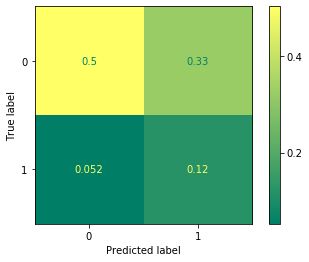

In [20]:
from sklearn.metrics import plot_confusion_matrix,  confusion_matrix

plot_confusion_matrix(bst_clf, X_test, y_test, cmap='summer', normalize='all')  
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams["font.size"] = 22
plt.show()

In [21]:
y_pred = bst_clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[54464, 35114],
       [ 5576, 12846]], dtype=int64)

In [22]:
results = pd.DataFrame({'True': y_test, 'Group':pd.cut(pd.Series(bst_clf.predict_proba(X_test)[:, 1]), np.arange(0,1.1, 0.1)).values, 'Probabilaty':bst_clf.predict_proba(X_test)[:, 1]})
results.groupby('Group').agg({'Probabilaty':['mean'], 'True':['mean' ,'count', 'sum']})

Probabilaty      True             
                  mean      mean  count   sum
Group                                        
(0.0, 0.1]    0.080018  0.022461   5387   121
(0.1, 0.2]    0.162161  0.043668   9618   420
(0.2, 0.3]    0.258297  0.075255  10697   805
(0.3, 0.4]    0.345298  0.094902  13888  1318
(0.4, 0.5]    0.457769  0.142396  20450  2912
(0.5, 0.6]    0.549042  0.219250  28935  6344
(0.6, 0.7]    0.648262  0.281737  11351  3198
(0.7, 0.8]    0.745177  0.351439   3682  1294
(0.8, 0.9]    0.820972  0.491423   3789  1862
(0.9, 1.0]    0.928940  0.729064    203   148

## SHAP Explainer

In [23]:
model = pipeline_clf['classifier']
X_train_1 = convert_X_to_df(pipeline_clf['data_pipeline'], X_train)

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_1)

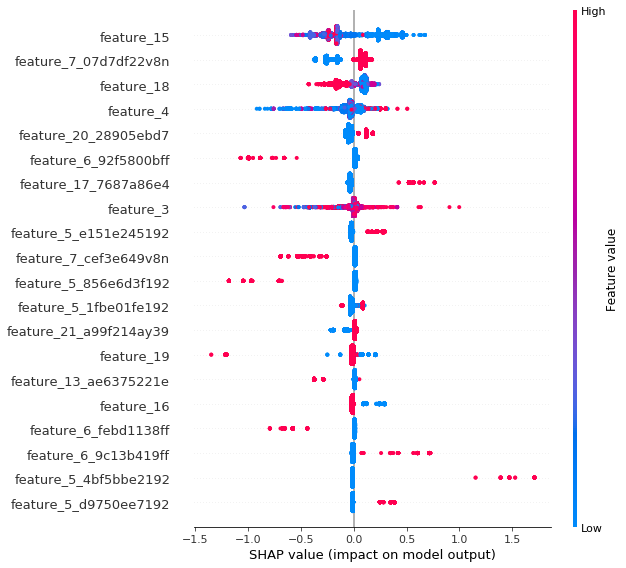

In [25]:
shap.summary_plot(shap_values, X_train_1)

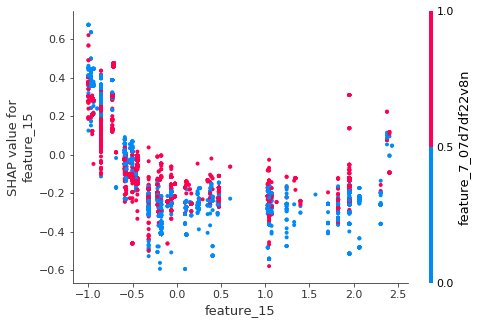

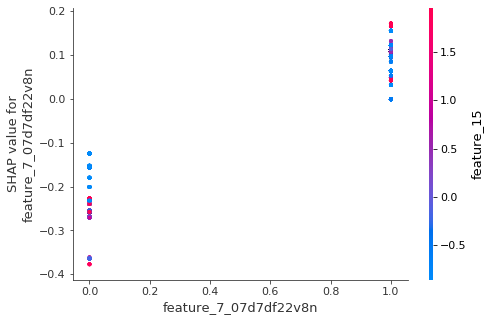

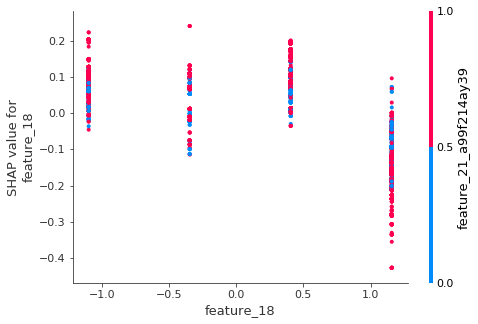

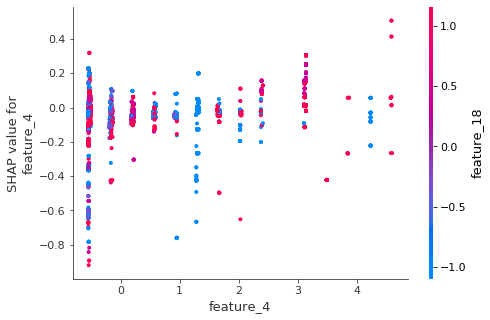

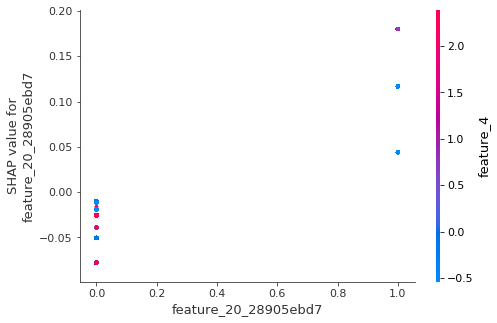

In [26]:
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, X_train_1)